In [1]:
import torch
from torch.utils.data import Dataset,DataLoader

In [2]:
img_folder = "/Data/Training/"
classes = {
            0: "Apple Granny Smith",
            1: "Apple Red 1",
            2: "Apple Golden 1",
            3: "Dates",
            4: "Nut Pecan",
            5: "Tangelo",
            6: "Kohlrabi",
            7: "Plum",
            8: "Peach",
            9: "Walnut"
        }

In [ ]:
import os
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {
            0: "Apple Granny Smith",
            1: "Apple Red 1",
            2: "Apple Golden 1",
            3: "Dates",
            4: "Nut Pecan",
            5: "Tangelo",
            6: "Kohlrabi",
            7: "Plum",
            8: "Peach",
            9: "Walnut"
        }
        self.class_to_int = {v: k for k, v in self.classes.items()}
        self.file_list = self._load_file_list()

    def _load_file_list(self):
        file_list = []
        for class_name in self.classes.values():
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                raise ValueError(f"Directory '{class_name}' not found in '{self.root_dir}'")
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    file_list.append((os.path.join(class_dir, filename), class_name))
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path, class_name = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_int[class_name]
        return image, label




In [ ]:
# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Train_ds = CustomDataset(root_dir=r'./Data/Training', transform=data_transform)
train_dl = DataLoader(Train_ds, batch_size=32, shuffle=True)


Test_ds = CustomDataset(root_dir=r'./Data/Test', transform=data_transform)
test_dl = DataLoader(Test_ds, batch_size=32, shuffle=True)

In [21]:
import cv2 as cv


img = cv.imread(r"Data/Training/Apple Granny Smith/0_100.jpg")
sift = cv.SIFT_create()

kp = sift.detect(img,None)

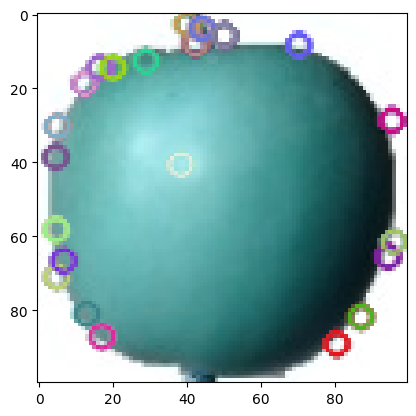

: 

In [25]:
img=cv.drawKeypoints(img,kp,img)

import matplotlib.pyplot as plt

plt.imshow(img)